# Common Neighbor Rule in PyC Subgraph (Th=100)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.proximity import *
from utils.graph_creation import *
from utils.visualization import *
from utils.common_neighbor_rule import *

### 1. Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [5]:
g_th100 = get_thresholded_graph(g_actual, axls, 100)
print(nx.info(g_th100))

Name: 
Type: DiGraph
Number of nodes: 111
Number of edges: 659
Average in degree:   5.9369
Average out degree:   5.9369


### 2. Common Neighbor Rule (OBS vs ER vs CFG)

In [6]:
%%time
# calculate common neighbor stats in the observation
obs_cnr_stats = get_cnr_stats(g_th100)

CPU times: user 244 ms, sys: 0 ns, total: 244 ms
Wall time: 241 ms


- "undir_pair" - number of pairs with [bin] common neighbor
- "dir_spair" - number of pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_ppair" - number of pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_conn" - number of connected pairs with [bin] common neighbor
- "dir_sconn" - number of connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_pconn" - number of connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_uni_sconn" - number of unidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_uni_pconn" - number of unidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_bi_sconn" - number of bidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_bi_pconn" - number of bidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_perc" - percentage of pairs with [bin] common neighbor to be connected
- "dir_sperc" - percentage of pairs with [bin] strict common successor to be connected
- "dir_pperc" - percentage of pairs with [bin] strict common predcessor to be connected

In [7]:
obs_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,2027.0,4676.0,3927.0,101.0,400.0,351.0,378.0,334.0,22.0,17.0,0.049827,0.085543,0.089381
1,1741.0,1031.0,1593.0,164.0,140.0,197.0,134.0,188.0,6.0,9.0,0.094199,0.135790,0.123666
2,1106.0,271.0,460.0,135.0,52.0,61.0,51.0,59.0,1.0,2.0,0.122061,0.191882,0.132609
3,637.0,85.0,106.0,102.0,20.0,19.0,20.0,18.0,0.0,1.0,0.160126,0.235294,0.179245
4,314.0,22.0,17.0,53.0,10.0,2.0,10.0,2.0,0.0,0.0,0.168790,0.454545,0.117647
5,145.0,14.0,2.0,31.0,5.0,0.0,5.0,0.0,0.0,0.0,0.213793,0.357143,0.000000
6,76.0,5.0,0.0,17.0,3.0,0.0,3.0,0.0,0.0,0.0,0.223684,0.600000,0.000000
7,27.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.000000,0.000000
8,19.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.526316,0.000000,0.000000
9,13.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.461538,0.000000,0.000000


In [8]:
%%time
# sample graphs from CFG model and compute CNR stats
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples = continuous_sample_cnr(g_th100, samples=s, niters=int(1e4))
cfg_cnr_stats, cfg_cnr_stats_std = cnr_mean_std(cfg_cnr_samples)


CPU times: user 33.2 s, sys: 0 ns, total: 33.2 s
Wall time: 38.4 s


In [13]:
# save sampled CNR stats from CFG model as intermediate data
cfg_cnr_stats.to_csv("saved/th100_cnr_cfg100.csv", index=False)
cfg_cnr_stats_std.to_csv("saved/th100_cnrstd_cfg100.csv", index=False)

In [14]:
# load precomputed CNR stats counts from CFG model
cfg_cnr_stats = pd.read_csv("saved/th100_cnr_cfg100.csv")
cfg_cnr_stats_std = pd.read_csv("saved/th100_cnrstd_cfg100.csv")

In [15]:
cfg_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,1939.39,4637.05,3886.65,118.78,404.22,367.75,393.70,356.00,10.52,11.75,0.061263,0.087171,0.094617
1,1782.02,1071.63,1660.47,164.32,151.87,196.42,145.44,189.74,6.43,6.68,0.092221,0.141682,0.118312
2,1145.70,279.54,446.21,139.87,51.39,58.20,48.97,56.13,2.42,2.07,0.122086,0.183649,0.130448
3,646.92,77.91,92.93,95.72,18.69,12.51,17.67,11.99,1.02,0.52,0.147930,0.239476,0.133790
4,322.07,24.76,16.33,56.63,7.02,2.49,6.55,2.35,0.47,0.14,0.175654,0.283114,0.150473
5,150.58,8.71,2.16,31.68,2.54,0.39,2.36,0.36,0.18,0.03,0.210405,0.296656,0.165107
6,65.88,3.21,0.22,16.22,1.19,0.04,1.10,0.04,0.09,0.00,0.245393,0.371452,0.040000
7,29.33,1.16,0.03,7.79,0.47,0.01,0.44,0.01,0.03,0.00,0.264944,0.300000,0.010000
8,13.10,0.55,0.00,3.55,0.24,0.00,0.23,0.00,0.01,0.00,0.265554,0.206667,0.000000
9,10.01,0.48,0.00,3.25,0.18,0.00,0.16,0.00,0.02,0.00,0.314639,0.153333,0.000000


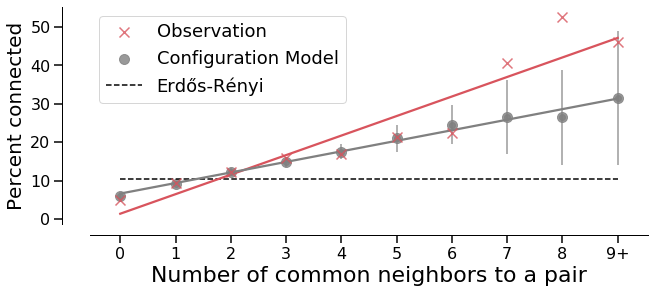

In [16]:
# plot CNR curves
E, N = len(g_th100.edges), len(g_th100.nodes)
ER_p_null = (1 - E / (N*(N-1)))**2

plot_cnr(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null, figsize=(10,4), fname="th100/th100_cnr")

In [17]:
# Pearson r^2 and p-value for OBS
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.8793027463711647, 6.106235706259406e-05)

In [18]:
# Pearson r^2 and p-value for CFG
pearson_r2(np.arange(10), cfg_cnr_stats["undir_perc"])

(0.9882549368633136, 5.227933798388896e-09)

### 3. Common Neighbor Rule (OBS vs gER vs gCFG)

In [19]:
%%time
# sample graphs from gCFG model and compute CNR stats
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples_GE = continuous_sample_cnr_GE(g_th100, samples=s, niters=int(1e4))
cfg_cnr_stats_GE, cfg_cnr_stats_std_GE = cnr_mean_std(cfg_cnr_samples_GE)


CPU times: user 42.4 s, sys: 144 ms, total: 42.5 s
Wall time: 42.4 s


In [20]:
# save sampled CNR stats from CFG model as intermediate data
cfg_cnr_stats_GE.to_csv("saved/th100_cnr_gcfg100.csv", index=False)
cfg_cnr_stats_std_GE.to_csv("saved/th100_cnrstd_gcfg100.csv", index=False)

In [21]:
# load precomputed CNR stats counts from CFG model
cfg_cnr_stats_GE = pd.read_csv("saved/th100_cnr_gcfg100.csv")
cfg_cnr_stats_std_GE = pd.read_csv("saved/th100_cnrstd_gcfg100.csv")

In [22]:
cfg_cnr_stats_GE

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,1985.21,4668.04,3934.68,120.24,402.77,368.71,387.55,352.51,15.22,16.20,0.060550,0.086282,0.093708
1,1794.42,1054.68,1631.28,164.01,147.65,190.05,139.70,181.00,7.95,9.05,0.091383,0.140004,0.116508
2,1146.60,270.40,432.68,140.05,50.97,56.41,47.38,53.48,3.59,2.93,0.122128,0.188438,0.130355
3,623.82,76.29,88.69,93.48,18.09,12.01,16.75,11.39,1.34,0.62,0.149855,0.237682,0.135146
4,307.34,22.04,15.03,54.97,6.13,2.40,5.68,2.23,0.45,0.17,0.178543,0.277715,0.161885
5,140.92,8.04,2.28,29.63,2.53,0.36,2.28,0.33,0.25,0.03,0.209385,0.323024,0.132167
6,60.88,2.97,0.34,14.61,0.95,0.06,0.85,0.06,0.10,0.00,0.239622,0.339857,0.040000
7,26.10,1.39,0.02,6.71,0.44,0.00,0.41,0.00,0.03,0.00,0.255985,0.282833,0.000000
8,11.39,0.68,0.00,3.28,0.27,0.00,0.23,0.00,0.04,0.00,0.277087,0.200000,0.000000
9,8.32,0.47,0.00,3.02,0.20,0.00,0.17,0.00,0.03,0.00,0.359294,0.160000,0.000000


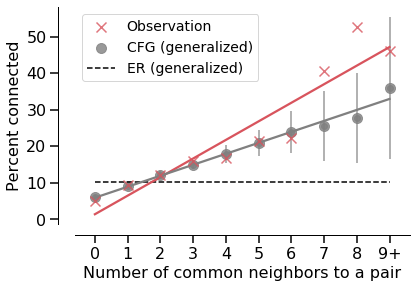

In [25]:
# plot CNR curves
_, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th100)
ER_p_null_GE = 1 - 2*two_pr_GE["pr_uni"] - two_pr_GE["pr_bi"]

plot_cnr(obs_cnr_stats, cfg_cnr_stats_GE, cfg_cnr_stats_std_GE, ER_p_null_GE, 
         figsize=(6,4), fontsizes=(16, 16, 16, 14), cfg_name="CFG (generalized)", er_name="ER (generalized)", fname="th100/th100_cnr_GE")

In [26]:
# Pearson r^2 and p-value for OBS
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.8793027463711647, 6.106235706259406e-05)

In [27]:
# Pearson r^2 and p-value for gCFG
pearson_r2(np.arange(10), cfg_cnr_stats_GE["undir_perc"])

(0.9791662604113113, 5.194917261971365e-08)

### 4. Common Neighbor Rule (OBS vs gER vs CFG)

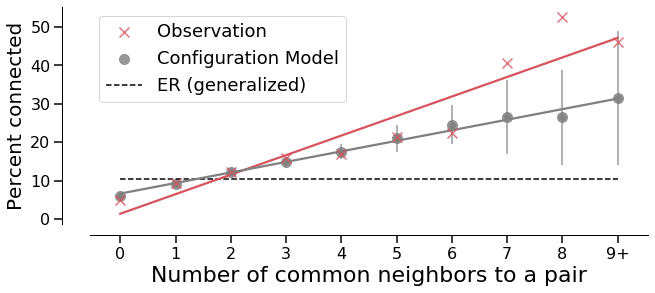

In [29]:
# plot CNR curves
plot_cnr(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null_GE, figsize=(10,4), 
         er_name="ER (generalized)", fname="th100/th100_cnr_CGE")